In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, precision_score
from xgboost import XGBClassifier
from scripts.csv_continue_to_ds_discreet import csvContinue2DSDiscreet
from scripts.evaluate_model import evaluate_predictions

In [2]:
X, y = csvContinue2DSDiscreet()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [4]:
ratio = sum(y_train == 0) / sum(y_train == 1)

model_1 = Pipeline([
  ('xgboost', XGBClassifier(random_state=0, scale_pos_weight=ratio))
])

In [5]:
scoring_metrics = {
    'roc_auc': 'roc_auc',
    'recall_classe0': make_scorer(recall_score, pos_label=0),
    'recall_classe1': make_scorer(recall_score, pos_label=1),
    'precision_classe0': make_scorer(precision_score, pos_label=0),
    'precision_classe1': make_scorer(precision_score, pos_label=1)
}

In [6]:
params = {
  'xgboost__n_estimators': [50, 100, 150],
  'xgboost__learning_rate': [0.01, 0.02, 0.05],
  'xgboost__max_depth': [5, 10]
}

cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(model_1, param_grid=params, cv=cv_stratified, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

In [7]:
gs

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgboost__learning_rate': [0.01, 0.02, ...], 'xgboost__max_depth': [5, 10], 'xgboost__n_estimators': [50, 100, ...]}"
,scoring,"{'precision_classe0': make_scorer(p..., pos_label=0), 'precision_classe1': make_scorer(p..., pos_label=1), 'recall_classe0': make_scorer(r..., pos_label=0), 'recall_classe1': make_scorer(r..., pos_label=1), ...}"
,n_jobs,-1
,refit,'roc_auc'
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [8]:
gs.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgboost__learning_rate': [0.01, 0.02, ...], 'xgboost__max_depth': [5, 10], 'xgboost__n_estimators': [50, 100, ...]}"
,scoring,"{'precision_classe0': make_scorer(p..., pos_label=0), 'precision_classe1': make_scorer(p..., pos_label=1), 'recall_classe0': make_scorer(r..., pos_label=0), 'recall_classe1': make_scorer(r..., pos_label=1), ...}"
,n_jobs,-1
,refit,'roc_auc'
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [9]:
(f'best_score: {gs.best_score_}; best_params: {gs.best_params_}')

"best_score: 0.8625536319305912; best_params: {'xgboost__learning_rate': 0.01, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 100}"

In [10]:
results = pd.DataFrame(gs.cv_results_)

In [11]:
def remake_best_estimator(params, X_train, y_train):
  
  ratio = sum(y_train == 0) / sum(y_train == 1)

  best_params = {
    'n_estimators': params['xgboost__n_estimators'],
    'learning_rate': params['xgboost__learning_rate'],
    'max_depth': params['xgboost__max_depth'],
  }

  model = Pipeline([
      ('xgboost', XGBClassifier(
          random_state=0,
          scale_pos_weight=ratio,
          n_estimators=best_params['n_estimators'],
          learning_rate=best_params['learning_rate'],
          max_depth=best_params['max_depth']
      ))
  ])
  return model.fit(X_train, y_train)

In [12]:
best_models = {}

In [13]:
best_models['roc_auc'] = remake_best_estimator(results.loc[results['mean_test_roc_auc'].idxmax()]['params'], X_train=X_train, y_train=y_train)
best_models['recall_0'] = remake_best_estimator(results.loc[results['mean_test_recall_classe0'].idxmax()]['params'], X_train=X_train, y_train=y_train)
best_models['recall_1'] = remake_best_estimator(results.loc[results['mean_test_recall_classe1'].idxmax()]['params'], X_train=X_train, y_train=y_train)
best_models['precision_0'] = remake_best_estimator(results.loc[results['mean_test_precision_classe0'].idxmax()]['params'], X_train=X_train, y_train=y_train)
best_models['precision_1'] = remake_best_estimator(results.loc[results['mean_test_precision_classe1'].idxmax()]['params'], X_train=X_train, y_train=y_train)

In [14]:
def evaluate_on_train_test_ensemble(models, X_train, y_train, X_test, y_test, threshold=0.5):
    print("Evaluating on training set")
    
    train_probas = pd.DataFrame()
    for i, model in enumerate(models):
        train_probas[f'model_{i}'] = models[model].predict_proba(X_train)[:, 1]
    
    ensemble_train_proba = train_probas.mean(axis=1)
    ensemble_train_pred = (ensemble_train_proba >= threshold).astype(int)
    
    evaluate_predictions(ensemble_train_pred, y_train, ensemble_train_proba)
    
    print("Evaluating on test set")
    
    test_probas = pd.DataFrame()
    for i, model in enumerate(models):
        test_probas[f'model_{i}'] = models[model].predict_proba(X_test)[:, 1]
    
    ensemble_test_proba = test_probas.mean(axis=1)
    ensemble_test_pred = (ensemble_test_proba >= threshold).astype(int)
    
    evaluate_predictions(ensemble_test_pred, y_test, ensemble_test_proba)


In [15]:
X.columns

Index(['age_is_null', 'isChild', 'isTeen', 'isAdult', 'isSenior', 'isOld',
       'IsAlone', 'IsSmallFamily', 'IsBigFamily', 'FirstClass', 'SecondClass',
       'ThirdClass', 'EmbarkedS', 'EmbarkedC', 'EmbarkedQ', 'Male'],
      dtype='object')

Evaluating on training set


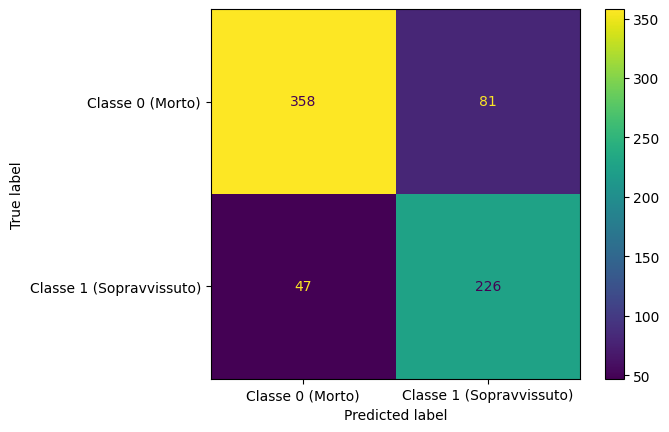

Percentuale di veri negativi: 81.55%
Percentuale di veri positivi: 82.78%
                          precision    recall  f1-score   support

        Classe 0 (Morto)       0.88      0.82      0.85       439
Classe 1 (Sopravvissuto)       0.74      0.83      0.78       273

                accuracy                           0.82       712
               macro avg       0.81      0.82      0.81       712
            weighted avg       0.83      0.82      0.82       712

[[358  81]
 [ 47 226]]


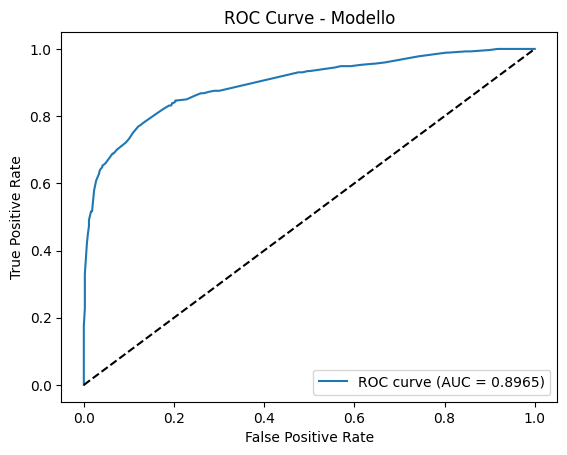

Evaluating on test set


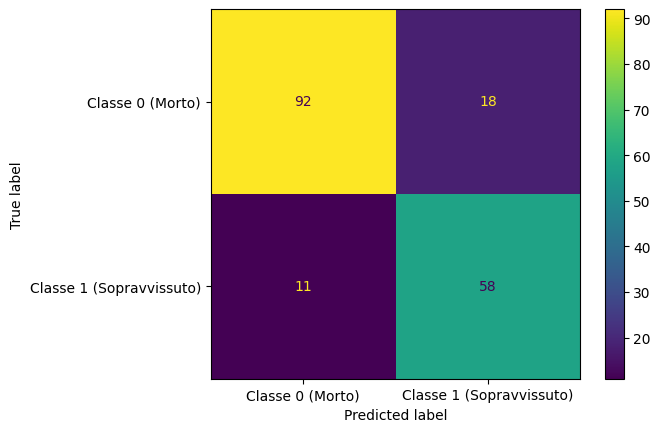

Percentuale di veri negativi: 83.64%
Percentuale di veri positivi: 84.06%
                          precision    recall  f1-score   support

        Classe 0 (Morto)       0.89      0.84      0.86       110
Classe 1 (Sopravvissuto)       0.76      0.84      0.80        69

                accuracy                           0.84       179
               macro avg       0.83      0.84      0.83       179
            weighted avg       0.84      0.84      0.84       179

[[92 18]
 [11 58]]


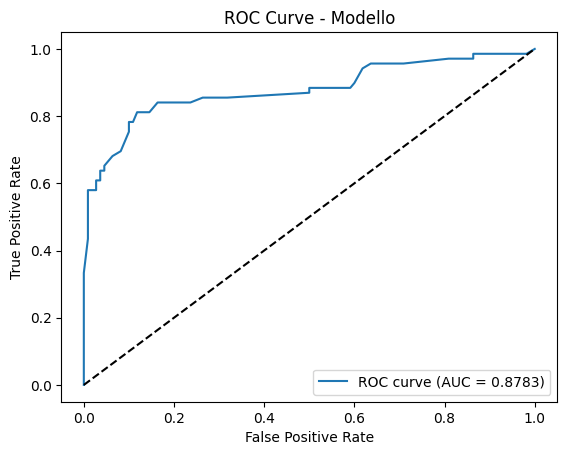

In [16]:
evaluate_on_train_test_ensemble(best_models, X_train, y_train, X_test, y_test)